# ResNetを再現実装

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torchsummary import summary

### ResNet-20アーキテクチャ実装

In [ ]:
def conv3x3(in_ch, out_ch, stride=1, padding=1):
    """3x3の畳み込み"""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=padding, bias=False)

class BasicBlock(nn.Module):
    """
    BasicBlock
    2層の畳み込みの後にショートカットを足す
    """
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

        # 入力と出力のチャンネル数を合わせるために、ストライドで間引き & ゼロチャンネルで埋める
        if stride != 1 or in_ch != out_ch:
            # オプションAのショートカット
            self.shortcut = lambda x: F.pad(
                x[:, :, ::stride, ::stride],
                (0, 0, 0, 0, 0, out_ch - in_ch),
            )
        else:
            self.shortcut = lambda x: x

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    """
    ResNet20
    入力画像のサイズは32x32
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_ch = 16

        self.conv1 = conv3x3(3, self.in_ch)                            # １層目

        self.bn1 = nn.BatchNorm2d(self.in_ch)
        self.layer1 = self._make_layer(out_ch=16, blocks=3, stride=1)  # 2~7層目
        self.layer2 = self._make_layer(out_ch=32, blocks=3, stride=2)  # 8~13層目
        self.layer3 = self._make_layer(out_ch=64, blocks=3, stride=2)  # 14~19層目

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)                           # 20層目

        # 重みの初期化
        self.apply(self._init_weights)

    def _make_layer(self, out_ch, blocks, stride):
        """
        BasicBlockをblocks回重ねた層を作成
        Args:
            out_ch (int): 出力チャンネル数
            blocks (int): BasicBlockを重ねる数
            stride (int): 畳み込みのストライド
        """
        layers = [BasicBlock(self.in_ch, out_ch, stride)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
# アーキテクチャに問題が無いか、ダミー入力で動作確認
resnet20 = ResNet20()
dummy_input = torch.randn(1, 3, 32, 32)
output = resnet20(dummy_input)
print(output.shape)

torch.Size([1, 10])


In [11]:
# turchsummaryでアーキテクチャとパラメータ数を確認
summary(resnet20, (3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

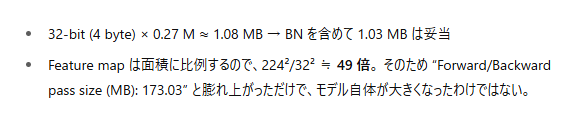

### CIFAR-10の読み込み & 前処理準備